In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


In [2]:
from matplotlib import pyplot
import numpy
import pandas

# Set seed of random number generator for reproducibility
numpy.random.seed(123)

# Implementing the kinetic model

In [3]:
# Defines the model class
class SequentialKinetic(BioprocessModel):
    
    def rhs(self, t, y):
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C = y
        
        # Unpacks the model parameters.
        k1 = self.model_parameters['k1']
        k2 = self.model_parameters['k2']
        
        # Defines the derivatives.
        dAdt = -k1 * A
        dBdt = k1 * A - k2*B
        dCdt = k2*B
        
        # Returns the derivative as list (or numpy array).
        # The order corresponds to the state vector.
        return [dAdt, dBdt, dCdt]
    
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'A0' : 50.0,
    'B0' : 2.5,
    'C0' : 0.0,
}


# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'k1' : 0.2,
    'k2' : 0.1,
}

In [4]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=['1st']
)

Run a forward simulation, using the "true" parameter values. This will be used to compare with the different estimation results.

In [5]:
simulation = caretaker.simulate(t=24)

Define the unknowns (and corresponding bounds) whose values are to be estimated from the data

In [6]:
unknowns = ['k1', 'k2', 'B0']
bounds = [(0, 100), (0, 100), (0, 50)]

## Use case 1

Each of the species A, B and C has been measured at different timepoints. Not all specied have been measured the same number of times. All the resulting data is collected in one file.

### Read the data, display the resulting DataFrame

In [7]:
df01 = pandas.read_excel('example08_data01.xlsx', header=[0, 1])
display(df01)

A                               B                       \
           time     values    errors       time     values    errors   
0  3.821007e-08  50.551747  4.640130  13.009415  19.880234  2.233278   
1  5.345975e-01  49.990885  2.890564  16.532655  14.724986  3.210822   
2  1.711986e+01   1.684952  0.233199        NaN        NaN       NaN   
3           NaN        NaN       NaN        NaN        NaN       NaN   

           C                       
        time     values    errors  
0   0.003848   0.059203  0.056457  
1   3.596686   5.290281  0.396654  
2  21.817515  40.116720  1.836385  
3  23.579135  43.147569  0.822713

### Extract some information, needed for creation of corresponding Measurement objects

In [8]:
display(df01.columns)

names = numpy.unique([mi[0] for mi in df01.columns])
display(names)

MultiIndex([('A',   'time'),
            ('A', 'values'),
            ('A', 'errors'),
            ('B',   'time'),
            ('B', 'values'),
            ('B', 'errors'),
            ('C',   'time'),
            ('C', 'values'),
            ('C', 'errors')],
           )

array(['A', 'B', 'C'], dtype='<U1')

### Create Measurement objects to feed the Caretaker

In [9]:
# Create an empty list, which will collect all Measurement objects
data01 = []

# Iterate over the first part of the MultiIndices which here represent the names of the measurements
for name in names:
    # Create corresponding Measurement object
    _measurement = Measurement(
        name=name, 
        replicate_id = '1st',
        timepoints=df01[(name, 'time')].to_numpy(), 
        values=df01[(name, 'values')].to_numpy(), 
        errors=df01[(name, 'errors')].to_numpy(),
    )
    # Append to list
    data01.append(_measurement)

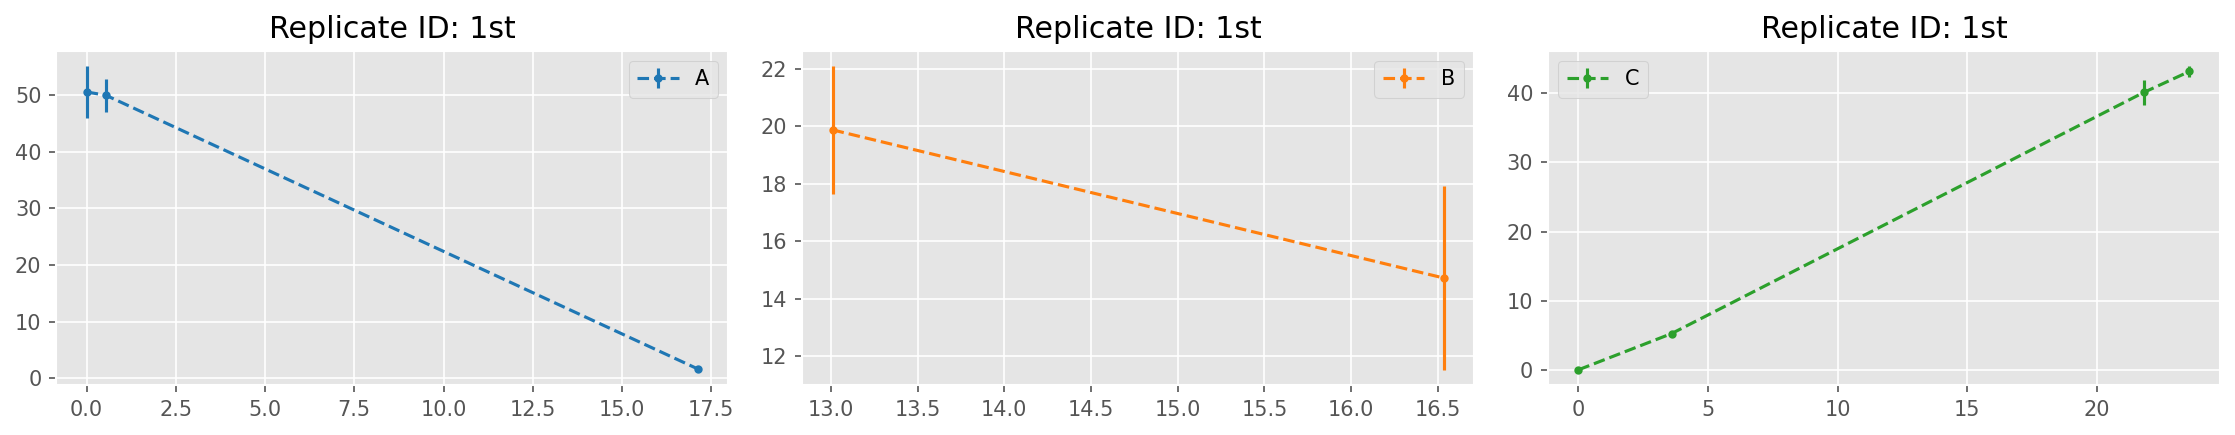

In [10]:
# Visualize the read data
_ = Visualization.show_kinetic_data(data01)

### Estimate parameters and uncertainties

In [11]:
est01, _ = caretaker.estimate(
    unknowns=unknowns, 
    bounds=bounds, 
    measurements=data01, 
    report_level=1,
)


----------Results from differential evolution optimizer

Estimated parameters:
B0: 1.7901650650833885
k1: 0.1972892970993869
k2: 0.10359440118258512

Runtime was 0.06 min


In [12]:
infos01 = caretaker.get_parameter_uncertainties(estimates=est01, measurements=data01, report_level=1)


Estimated parameters:
----------
B0: 1.79e+00 +/- 1.52e+00 (84.99 %)
k1: 1.97e-01 +/- 7.91e-03 (4.01 %)
k2: 1.04e-01 +/- 9.62e-03 (9.28 %)


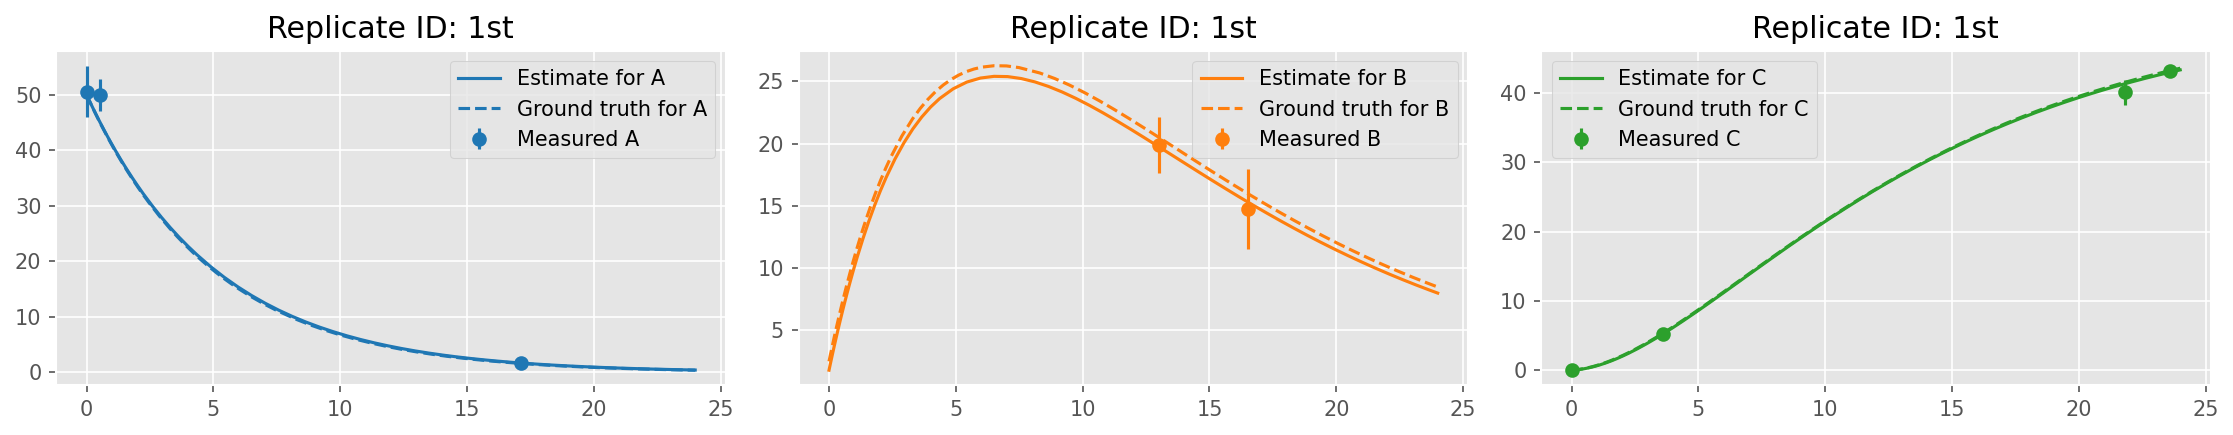

In [13]:
_ = Visualization.compare_estimates(parameters=est01, measurements=data01, caretaker=caretaker, truth=simulation)

## Example 2

Each of the species (A, B, and C) has been measured at a predefined schedule. The resulting data points (and errors) thus share the same time axis. The data is stored in a single file.

In [14]:
df02 = pandas.read_excel('example08_data02.xlsx', header=[0, 1], index_col=0)
display(df02)

A                    B                    C          
time     values    errors     values    errors     values    errors
0     46.703149  1.893154   2.555302  0.346182   0.031302  0.083571
1     43.462695  3.787488   9.873612  0.953270   0.740879  0.156047
2     35.355329  5.280869  17.433449  3.498709   2.343477  0.221989
5     18.394964  3.661686  23.822466  2.809217   8.169900  0.294373
10     6.846903  0.589329  22.704544  2.666017  21.284320  2.218041
15     2.841027  0.205954  15.193434  2.051847  33.839825  1.541375
20     0.805919  0.224613  12.492230  0.803941  39.587814  4.713812

In [15]:
# First, get the names of the measurement. These are represented by the first part of the pandas MultiIndex object
display(df02.columns)

names = numpy.unique([mi[0] for mi in df02.columns])
display(names)

MultiIndex([('A', 'values'),
            ('A', 'errors'),
            ('B', 'values'),
            ('B', 'errors'),
            ('C', 'values'),
            ('C', 'errors')],
           names=[None, 'time'])

array(['A', 'B', 'C'], dtype='<U1')

In [16]:
# Create an empty list, which will collect all Measurement objects
data02 = []

# Iterate over the first part of the MultiIndices which here represent the names of the measurements
for name in names:
    # Create corresponding Measurement object
    _measurement = Measurement(
        name=name, 
        replicate_id = '1st', 
        timepoints=df02.index, 
        values=df02[(name, 'values')].to_numpy(), 
        errors=df02[(name, 'errors')].to_numpy(),
    )
    # Append to list
    data02.append(_measurement)

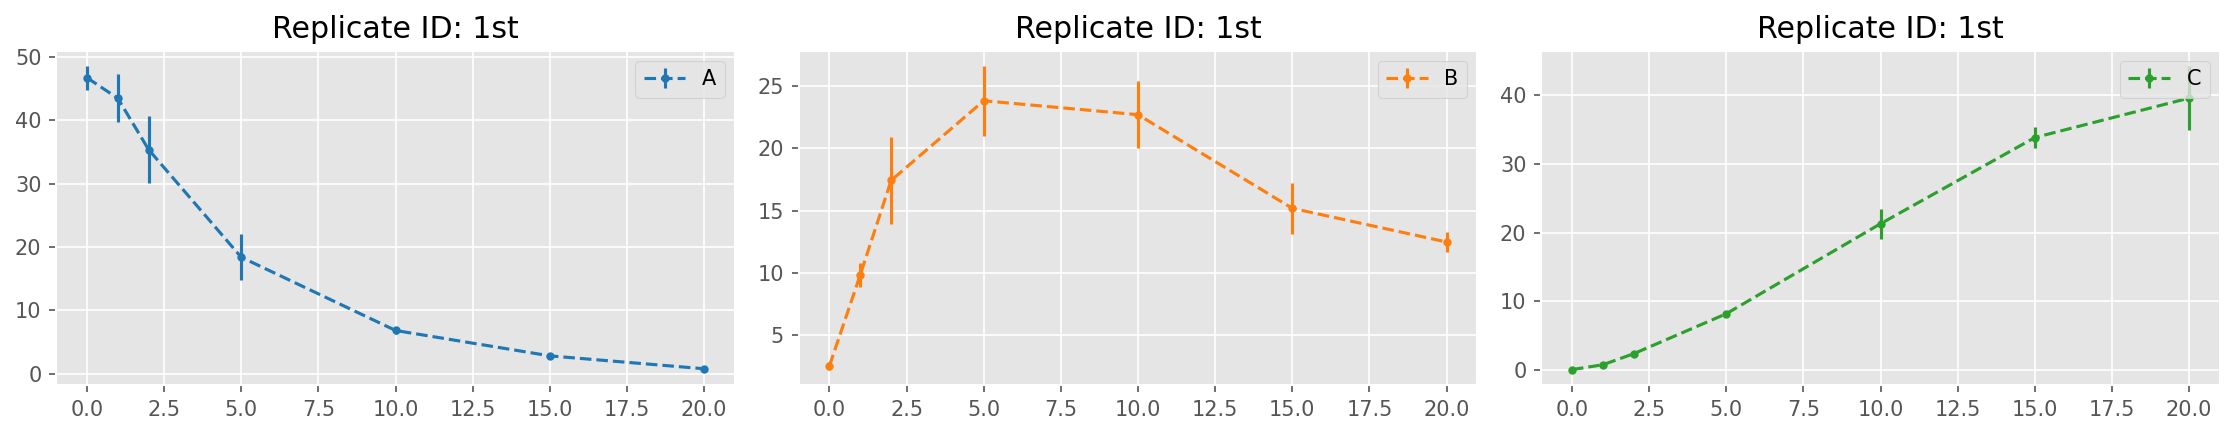

In [17]:
# Visualize the read data
_ = Visualization.show_kinetic_data(data02)

In [18]:
est02, _ = caretaker.estimate(
    unknowns=unknowns, 
    bounds=bounds, 
    measurements=data02, 
    report_level=1,
)


----------Results from differential evolution optimizer

Estimated parameters:
B0: 2.477747448723845
k1: 0.1934330118116357
k2: 0.10045442673103998

Runtime was 0.06 min


In [19]:
infos02 = caretaker.get_parameter_uncertainties(estimates=est02, measurements=data02, report_level=1)


Estimated parameters:
----------
B0: 2.48e+00 +/- 3.01e-01 (12.16 %)
k1: 1.93e-01 +/- 3.80e-03 (1.97 %)
k2: 1.00e-01 +/- 3.05e-03 (3.04 %)


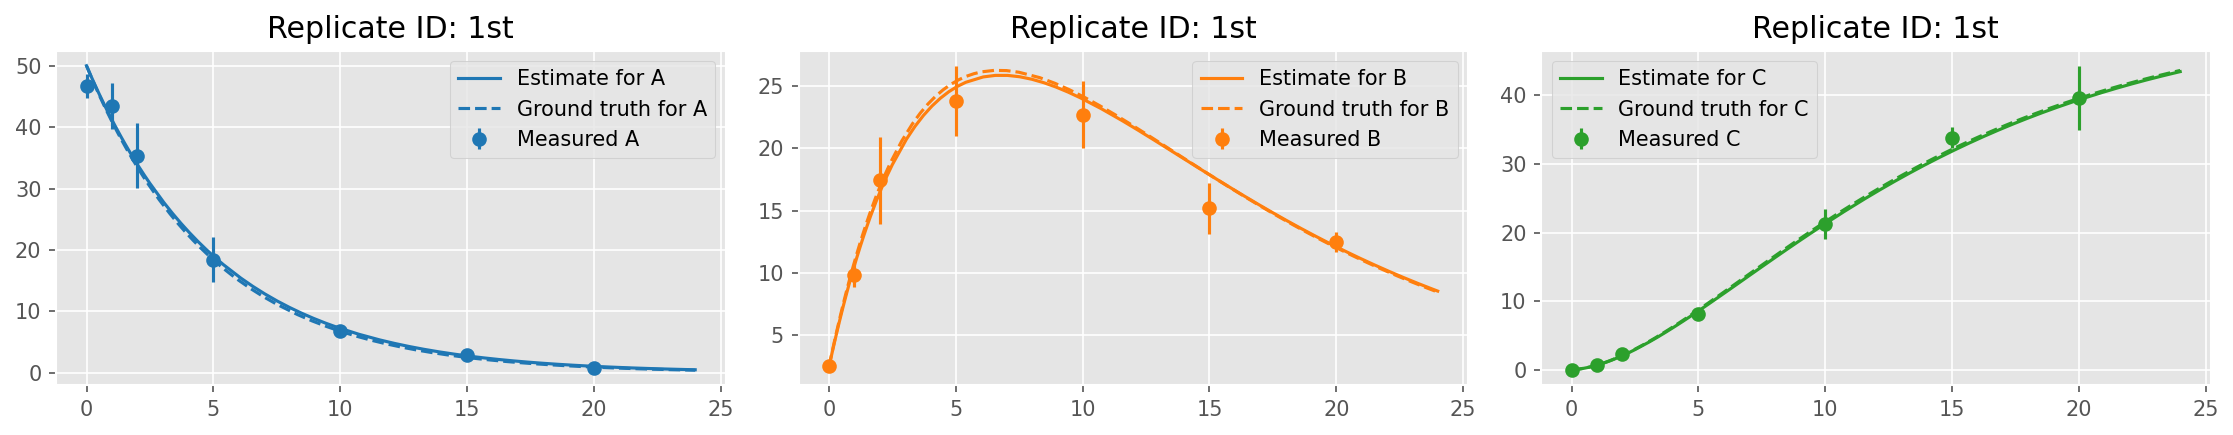

In [20]:
_ = Visualization.compare_estimates(parameters=est02, measurements=data02, caretaker=caretaker, truth=simulation)

## Use case 3

The data for each set of measurements (i.e., for species A, B, and C) is collected in one file. The time points of sampling were prefined, but not all species have been measured at each timepoint. For those species, the corresponding cells in the file are empty.

In [21]:
df03 = pandas.read_excel('example08_data03.xlsx', header=[0, 1], index_col=0)
display(df03)

A                    B                    C          
time     values    errors     values    errors     values    errors
0           NaN       NaN        NaN       NaN   0.031302  0.083571
1     43.462695  3.787488   9.873612  0.953270        NaN       NaN
2     35.355329  5.280869        NaN       NaN   2.343477  0.221989
5           NaN       NaN  23.822466  2.809217   8.169900  0.294373
10          NaN       NaN  22.704544  2.666017        NaN       NaN
15          NaN       NaN  15.193434  2.051847        NaN       NaN
20     0.805919  0.224613  12.492230  0.803941  39.587814  4.713812

In [22]:
names = numpy.unique([mi[0] for mi in df03.columns])

In [23]:
# Create an empty list, which will collect all Measurement objects
data03 = []

# Iterate over the first part of the MultiIndices which here represent the names of the measurements
for name in names:
    # Create corresponding Measurement object
    _measurement = Measurement(
        name=name, 
        replicate_id = '1st',  
        timepoints=df03.index, 
        values=df03[(name, 'values')].to_numpy(), 
        errors=df03[(name, 'errors')].to_numpy(),
    )
    # Append to list
    data03.append(_measurement)

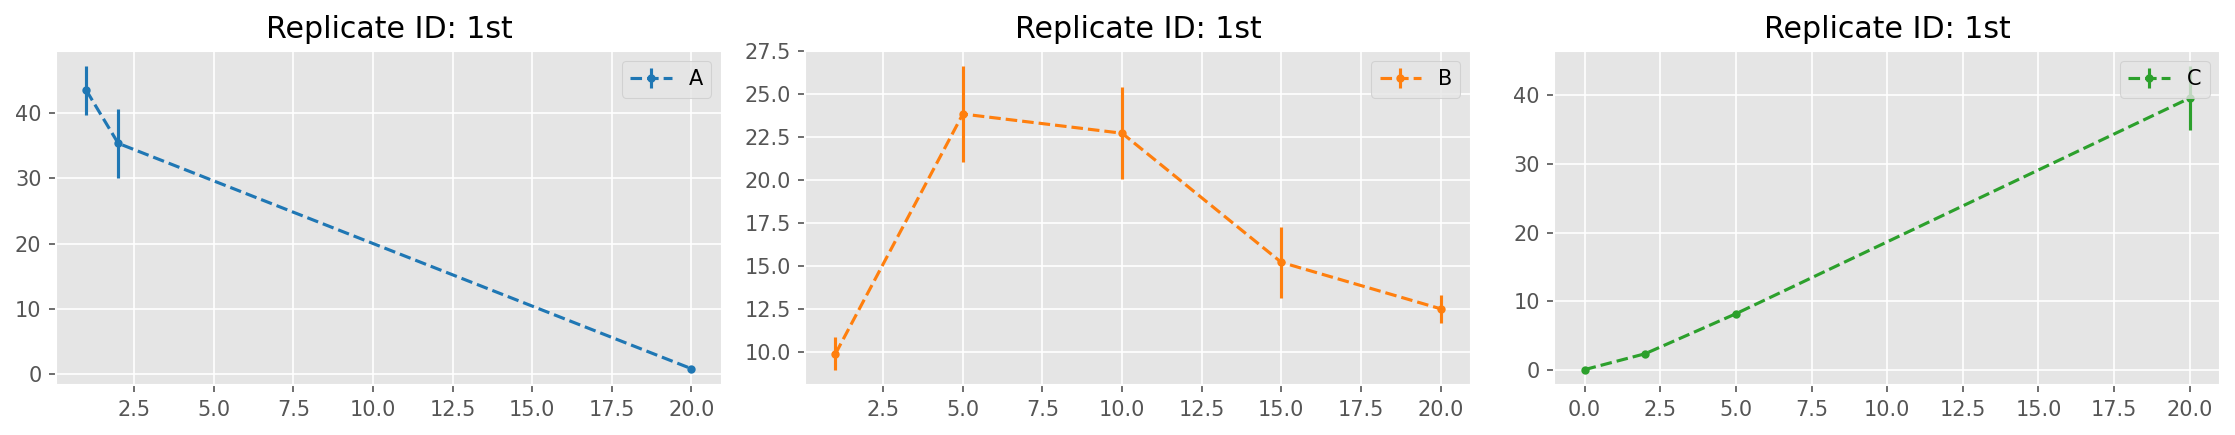

In [24]:
# Visualize the read data
_ = Visualization.show_kinetic_data(data03)

In [25]:
est03, _ = caretaker.estimate(
    unknowns=unknowns, 
    bounds=bounds, 
    measurements=data03, 
    report_level=1,
)


----------Results from differential evolution optimizer

Estimated parameters:
B0: 1.81109466881617
k1: 0.1980986015131279
k2: 0.09977013034328129

Runtime was 0.06 min


In [26]:
infos03 = caretaker.get_parameter_uncertainties(estimates=est03, measurements=data03, report_level=1)


Estimated parameters:
----------
B0: 1.81e+00 +/- 7.81e-01 (43.12 %)
k1: 1.98e-01 +/- 1.11e-02 (5.61 %)
k2: 9.98e-02 +/- 3.82e-03 (3.83 %)


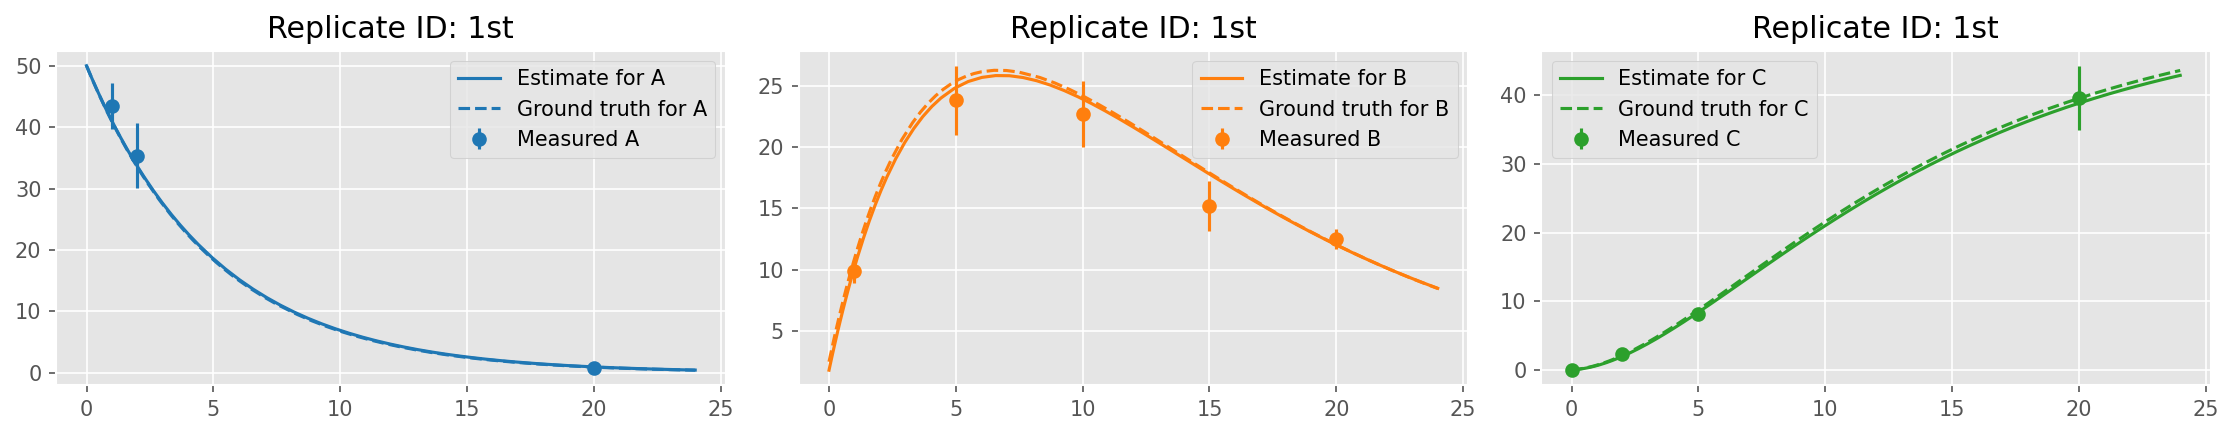

In [27]:
_ = Visualization.compare_estimates(parameters=est03, measurements=data03, caretaker=caretaker, truth=simulation)

## Use case 4

The experiment (called replicate "1st") from the previous use case was repeated (resulting in replicate "2nd"). Some some data was aquired and is stored in another sheet of the measurement data file.

In [28]:
df04 = pandas.read_excel('example08_data04.xlsx', header=[0, 1], index_col=0, sheet_name=None)
display(df04)

{'1st':               A                    B                    C          
 time     values    errors     values    errors     values    errors
 0           NaN       NaN        NaN       NaN   0.031302  0.083571
 1     43.462695  3.787488   9.873612  0.953270        NaN       NaN
 2     35.355329  5.280869        NaN       NaN   2.343477  0.221989
 5           NaN       NaN  23.822466  2.809217   8.169900  0.294373
 10          NaN       NaN  22.704544  2.666017        NaN       NaN
 15          NaN       NaN  15.193434  2.051847        NaN       NaN
 20     0.805919  0.224613  12.492230  0.803941  39.587814  4.713812,
 '2nd':               A                    B                    C          
 time     values    errors     values    errors     values    errors
 0     46.703149  1.893154   2.555302  0.346182        NaN       NaN
 1           NaN       NaN        NaN       NaN   0.740879  0.156047
 2           NaN       NaN  17.433449  3.498709        NaN       NaN
 5     18.394964  3

The returned data type is a dictionary, with the sheetnames as keys and the corresponding DataFrames as values.

In [29]:
# Create an empty list, which will collect all Measurement objects
data04 = []

# Iterate over replicates
for _replicate_id in df04.keys():
    _df = df04[_replicate_id]
    names = numpy.unique([mi[0] for mi in _df.columns])
    for name in names:
        # Create corresponding Measurement object
        _measurement = Measurement(
            name=name, 
            replicate_id = _replicate_id,  
            timepoints=_df.index, 
            values=_df[(name, 'values')].to_numpy(), 
            errors=_df[(name, 'errors')].to_numpy(),
        )
        # Append to list
        data04.append(_measurement)

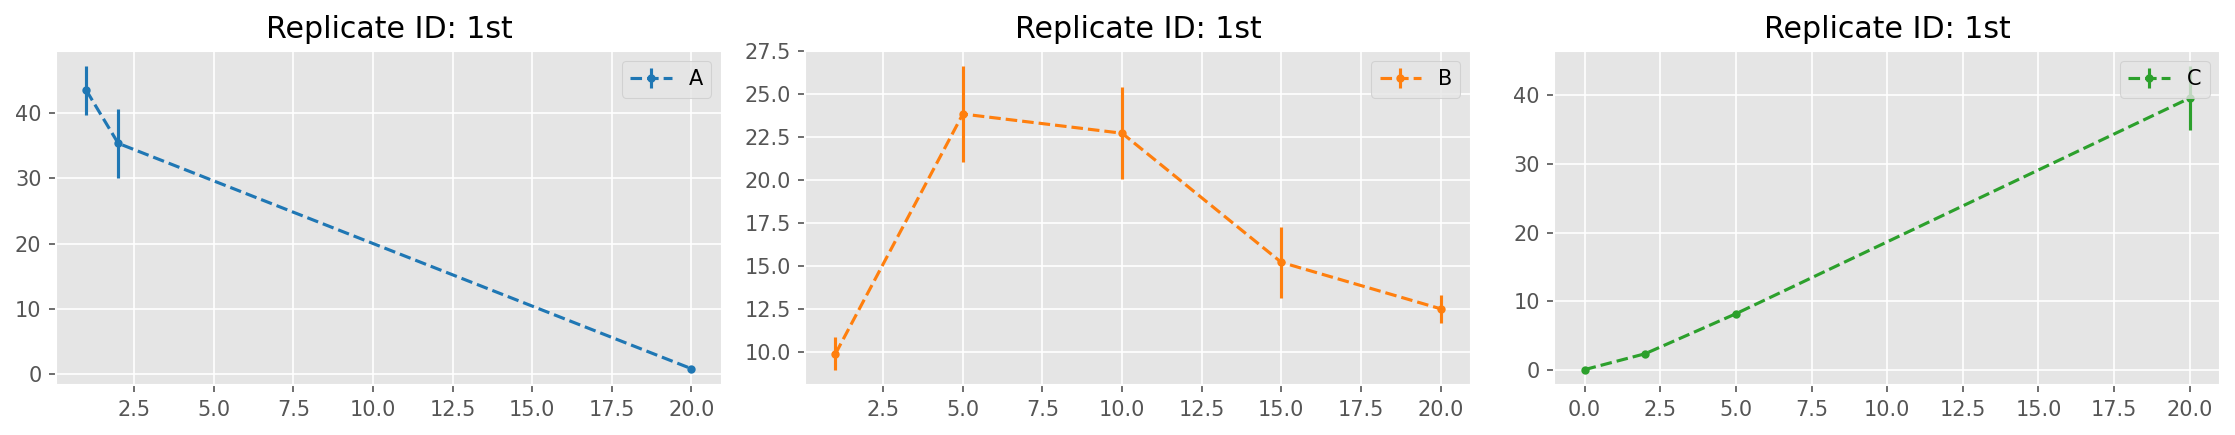

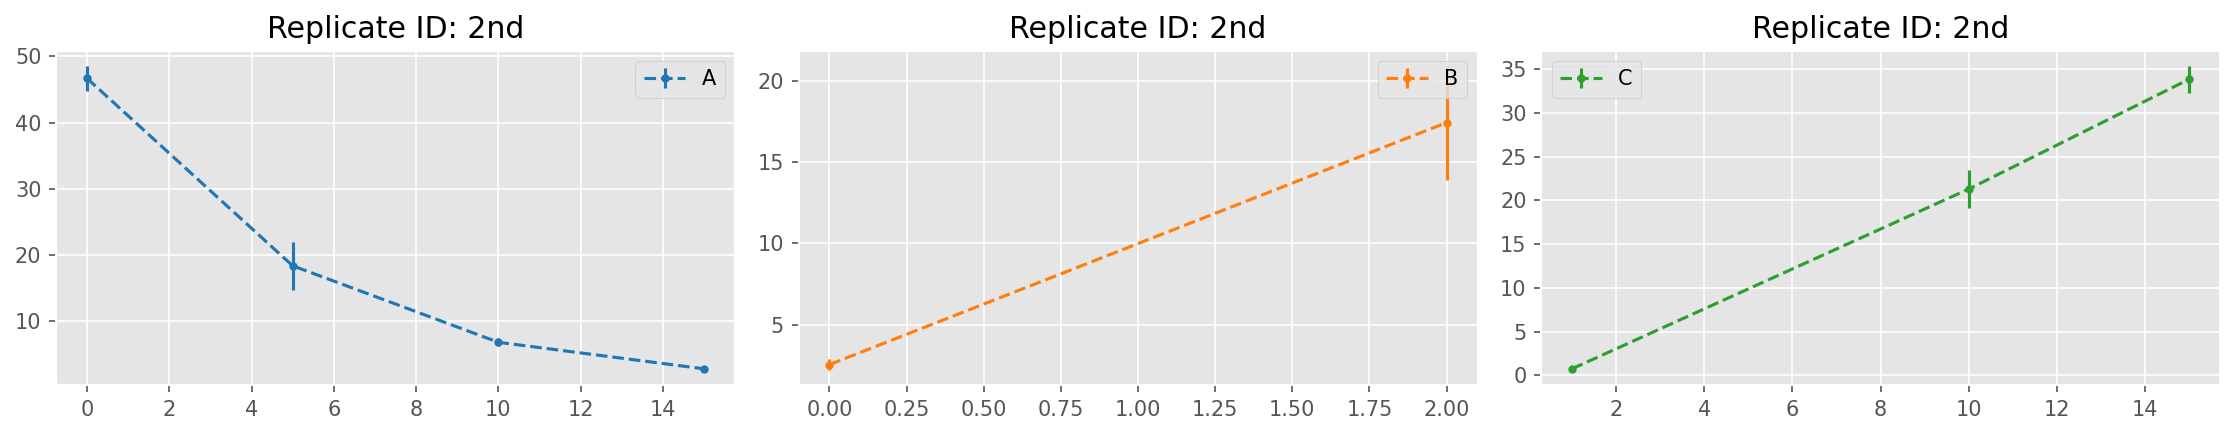

In [30]:
# Visualize the read data
_ = Visualization.show_kinetic_data(data04)

The Caretaker instance needs to know that there are more than one repliates. This is done by using its method `add_replicate()`.

In [31]:
caretaker.add_replicate(replicate_id='2nd')

In [32]:
est04, _ = caretaker.estimate(
    unknowns=unknowns, 
    bounds=bounds, 
    measurements=data04, 
    report_level=1,
)


----------Results from differential evolution optimizer

Estimated parameters:
B0: 2.4859538606053735
k1: 0.19344483137551466
k2: 0.10040648556161781

Runtime was 0.13 min


In [33]:
infos04 = caretaker.get_parameter_uncertainties(estimates=est04, measurements=data04, report_level=1)


Estimated parameters:
----------
B0: 2.49e+00 +/- 3.01e-01 (12.12 %)
k1: 1.93e-01 +/- 3.80e-03 (1.97 %)
k2: 1.00e-01 +/- 3.05e-03 (3.04 %)


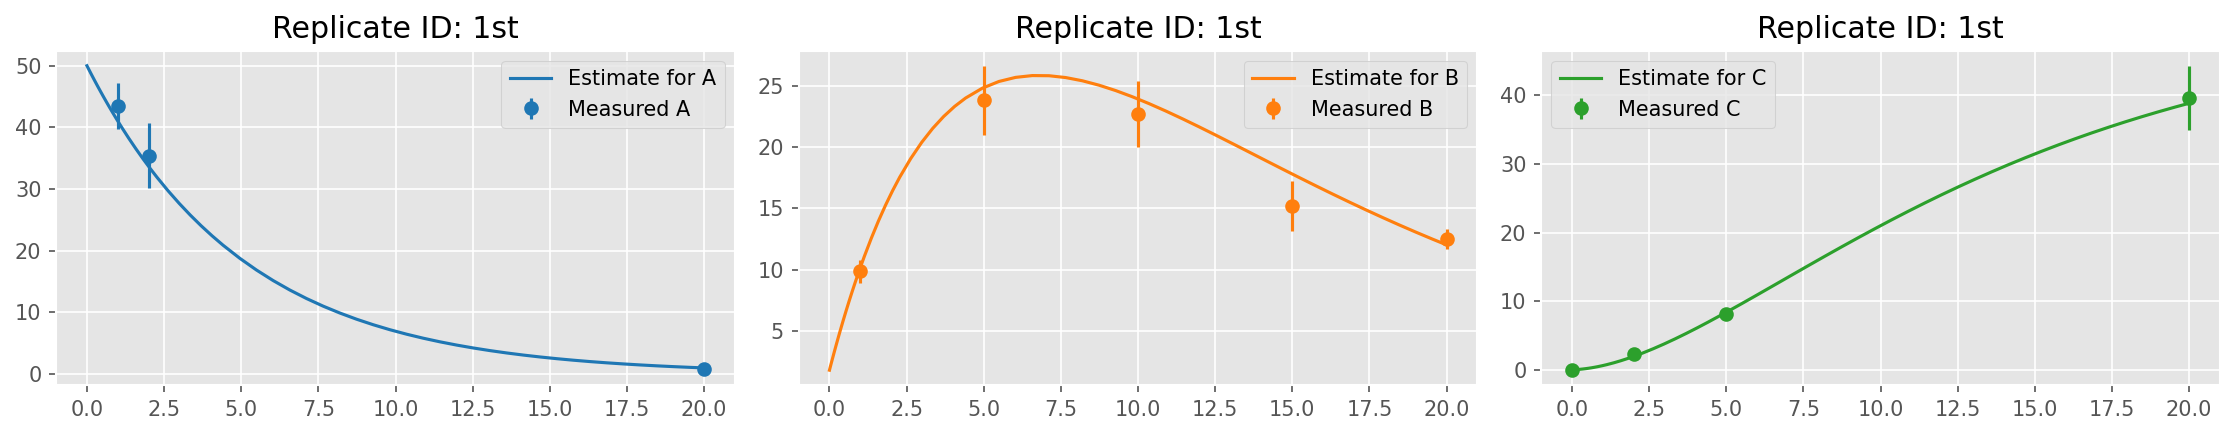

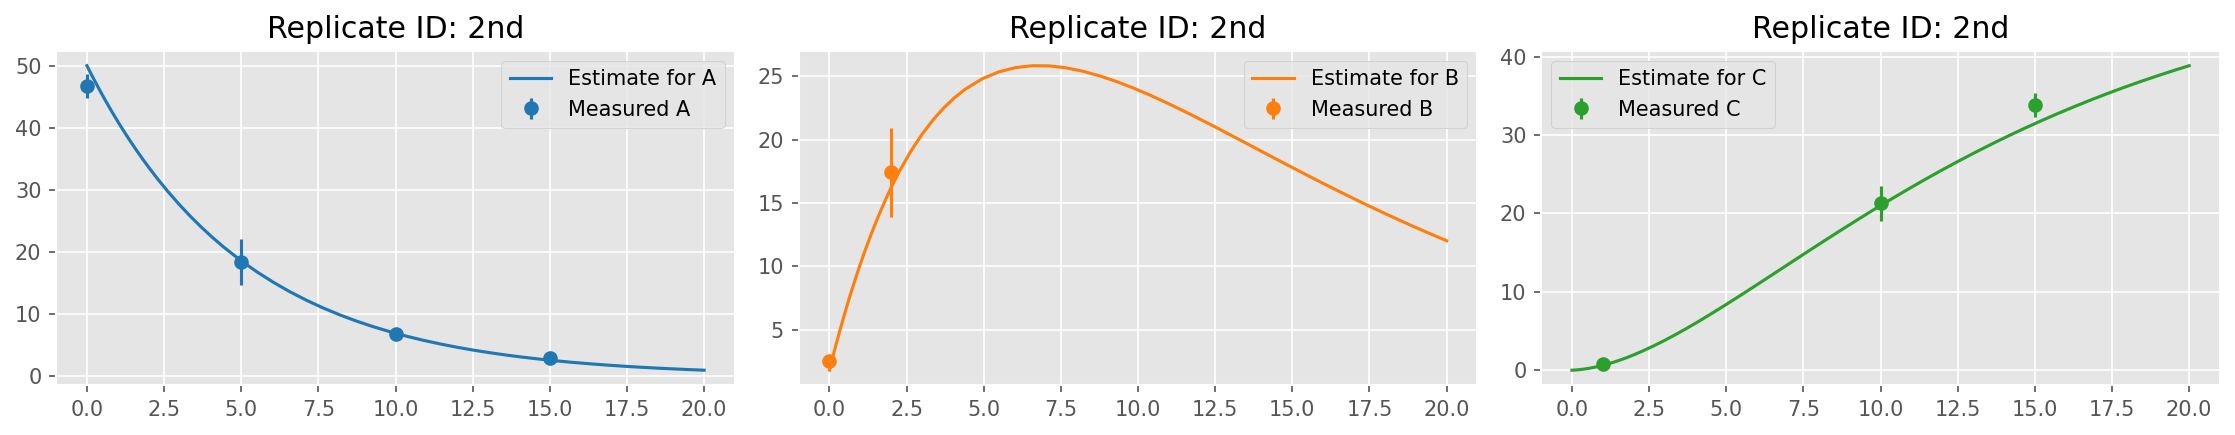

In [34]:
_ = Visualization.compare_estimates(parameters=est03, measurements=data04, caretaker=caretaker)

# Compare parameter estimation results for the different data sets



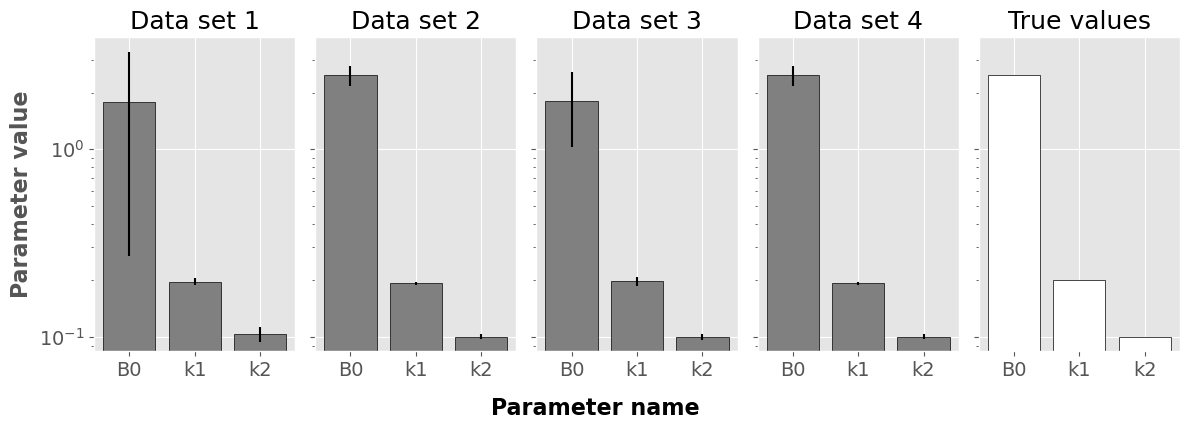

In [35]:
truth = {'Values' : [2.5, 0.2, 0.1], 'StdErrs' : [0, 0.0, 0.0]}
infos = [infos01, infos02, infos03, infos04, truth]
_data = {}
for i in range(len(infos)):
    _data[(f'Data set {i}', 'Values')] = infos[i]['Values']
    _data[(f'Data set {i}', 'StdErrs')] = infos[i]['StdErrs']
df = pandas.DataFrame(_data, index=['B0', 'k1', 'k2'])

nrows = 1
ncols = 5
fig, ax = pyplot.subplots(dpi=100, nrows=nrows, ncols=ncols, figsize=(12, 4), sharex=True, sharey=True)
for i, _ax in enumerate(ax.flat):
    if i == 4:
        title = 'True values'
        fcol = 'white'
        ecol = 'black'
    else:
        title = f'Data set {i+1}'
        fcol = 'grey'
        ecol = 'black'
    _ax.bar(
        x=df.index, 
        height=df[(f'Data set {i}', 'Values')], 
        yerr=df[(f'Data set {i}', 'StdErrs')], 
        facecolor=fcol, edgecolor=ecol)
    _ax.xaxis.set_tick_params(labelsize=14)
    _ax.yaxis.set_tick_params(labelsize=14)
    _ax.set_yscale('log')
    _ax.set_title(title, size=18)

ax.flat[0].set_ylabel('Parameter value', size=16, fontweight='bold')
fig.text(0.5, -0.05, 'Parameter name', ha='center', fontweight='bold', size=16)
fig.tight_layout()